# Aprenentatge profund per a imatges

A les lliçons anteriors, hem treballat extensament amb **dades tabulars**. Aquests conjunts de dades són generalment fàcils de representar i analitzar utilitzant eines com `pandas`, `scikit-learn` i diversos models estadístics.

Tanmateix, les **imatges** són fonamentalment diferents tant en estructura com en contingut. En lloc de files i columnes amb característiques etiquetades explícitament, una imatge és una graella de valors de píxels, normalment en 2D per a escala de grisos o en 3D per a color (alçada × amplada × canals). Per exemple, una imatge en color de mida 224×224 píxels amb 3 canals de color (RGB) conté més de 150.000 valors en brut, cap dels quals no està etiquetat amb característiques interpretables per humans com “edat” o “ingrés”.

Aquesta diferència condueix a diversos reptes importants:

- **Alta dimensionalitat**: Les imatges contenen moltes més característiques (píxels) que els conjunts de dades tabulars típics, cosa que augmenta la complexitat computacional i el risc de *overfitting*.
- **Estructura espacial**: Els píxels propers en una imatge sovint estan relacionats, formant vores, textures i patrons. Els models tabulars generalment no capten aquestes dependències locals.
- **Bretxa semàntica**: La relació entre els píxels en brut i els conceptes significatius (com un moic, una cara o un senyal de trànsit) és complexa i no lineal, i requereix models sofisticats per salvar aquesta bretxa.


En aquest mòdul explorarem com treballar amb dades d’imatges Per fer-ho, tornarem a utilitzar `PyTorch`.

## *Batches*

Quan entrenem models d’aprenentatge profund amb imatges, no alimentem tot el conjunt de dades alhora, com fèiem amb les dades tabulars. En lloc d’això, agrupem múltiples imatges en *batches*.

Un *batch* és una col·lecció de mostres (p. ex. imatges i les seves etiquetes) processades juntes en una sola passada endavant i enrere. Com a resultat les dades d'imatge són representades com un tensor de 4 dimensions:

```(batch_size, channels, height, width)
```

## El conjunt de dades MNIST

Per començar a treballar amb dades d’imatges en la pràctica, utilitzarem un dels conjunts de dades de referència més coneguts: **MNIST**. **MNIST** significa *Modified National Institute of Standards and Technology*. Consta de **70.000 imatges en escala de grisos** de xifres manuscrites (del 0 al 9), dividides en:

- **60.000 imatges d’entrenament**
- **10.000 imatges de prova**

Cada imatge és:

- **28 × 28 píxels**
- **En escala de grisos** (és a dir, un sol canal)
- **Etiquetada** amb la xifra correcta (0–9)

El conjunt de dades MNIST ha estat àmpliament utilitzat com a banc de proves per a algorismes d’aprenentatge automàtic i aprenentatge profund. Aquest conjunt de dades és ideal per aprendre perquè és petit, net i ja preprocesat, però alhora ofereix una complexitat realista en les xifres manuscrites.

### Exemple d’imatges MNIST

A continuació es mostra una mostra de xifres MNIST:

![MNIST Examples](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

Cada fila a la imatge anterior mostra les xifres del 0 al 9 escrites per persones diferents. Com pots veure, algunes xifres s’escriuen de maneres molt diferents, i és per això que necessitem l’aprenentatge automàtic per reconèixer-les automàticament.

In [2]:
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from tqdm import tqdm

## Carrega de dades

El processament de dades, com ja hem vist, és una part fonamental de qualsevol projecte d'aprenentatge profund. Per treballar amb dades de manera eficient, PyTorch ofereix dues classes: ``Dataset`` i ``DataLoader``.

El ``Dataset`` és una classe que representa un conjunt de dades. Serveix per carregar, transformar i accedir als elements individuals del conjunt. PyTorch inclou diversos datasets predefinits com MNIST, CIFAR-10 o ImageNet, però també podem crear els nostres propis datasets personalitzats heretant de torch.utils.data.Dataset i implementant els mètodes __len__() i __getitem__().

Un cop tenim el dataset, el ``DataLoader`` s’encarrega de gestionar la manera com aquestes dades s’entreguen al model. Permet dividir les dades en **batches**, barrejar-les (shuffle) i carregar-les en paral·lel utilitzant múltiples fils (*workers*).

In [3]:
BATCH_SIZE = 64
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset_train = datasets.MNIST(root='data', train=True, download=True, transform=transform)
dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE)

dataset_val = datasets.MNIST(root='data', train=False, download=True, transform=transform)
dataloader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE)

In [4]:
for img, gt in dataset_train:
	print(img.shape)
	print(gt)
	break

torch.Size([1, 28, 28])
5


In [5]:
for batch, gt in dataloader_train:
	print(batch.shape)
	print(gt.shape)
	break

torch.Size([64, 1, 28, 28])
torch.Size([64])


`nn.Sequential`` és una manera senzilla de construir una xarxa neuronal apilant les capes en ordre.

És útil quan el teu model és una cadena lineal de capes, sense ramificacions ni lògica personalitzada.

In [6]:
mlp_net = nn.Sequential(
    torch.nn.Linear(784, 10),
    nn.ReLU(),
    torch.nn.Linear(10, 10),
    torch.nn.Dropout(0.2),
    nn.ReLU(),
    torch.nn.Linear(10, 10)
)

### Entrenament

In [7]:
EPOCHS = 5
loss_fn = nn.CrossEntropyLoss()
LR = 1e-3
optimizer = torch.optim.Adam(mlp_net.parameters(), lr=LR)

In [8]:
running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

for t in tqdm(range(EPOCHS), desc="Epochs"):
    batch_loss = 0
    batch_acc = 0

    batch_val_loss = 0
    batch_val_acc = 0

    i_batch = 0
    for i_batch, (x, y) in enumerate(dataloader_train):  # We have to iter the batches.
        mlp_net.train()
        x = x.reshape(x.shape[0], -1)  # Flatten images

        optimizer.zero_grad()
        y_pred = mlp_net(x)

        # 1. LOSS CALCULATION
        loss = loss_fn(y_pred, y)

        # 2. GRADIENT
        mlp_net.zero_grad()
        loss.backward()

        # 3. OPTIMISATION
        with torch.no_grad():
            optimizer.step()

        # 4. EVALUATION
        mlp_net.eval()  # Mode avaluació de la xarxa

        y_pred = mlp_net(x)
        y_pred_binary = torch.argmax(y_pred, 1).double()

        batch_loss += (loss_fn(y_pred, y).detach())
        batch_acc += accuracy_score(y_pred_binary.detach(), y.detach())

    for i_val_batch, (x_val, y_val) in enumerate(dataloader_val):
        mlp_net.eval()
        x_val = x_val.reshape(x_val.shape[0], -1)  # Flatten

        y_val_pred = mlp_net(x_val)
        y_val_pred_binary = torch.argmax(y_val_pred, 1).double()

        batch_val_loss += (loss_fn(y_val_pred, y_val).detach())
        batch_val_acc += accuracy_score(y_val_pred_binary.detach(), y_val.detach())

    running_test_loss.append(batch_val_loss / (i_val_batch + 1))
    running_test_acc.append(batch_val_acc / (i_val_batch + 1))

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

Epochs: 100%|██████████| 5/5 [00:07<00:00,  1.45s/it]


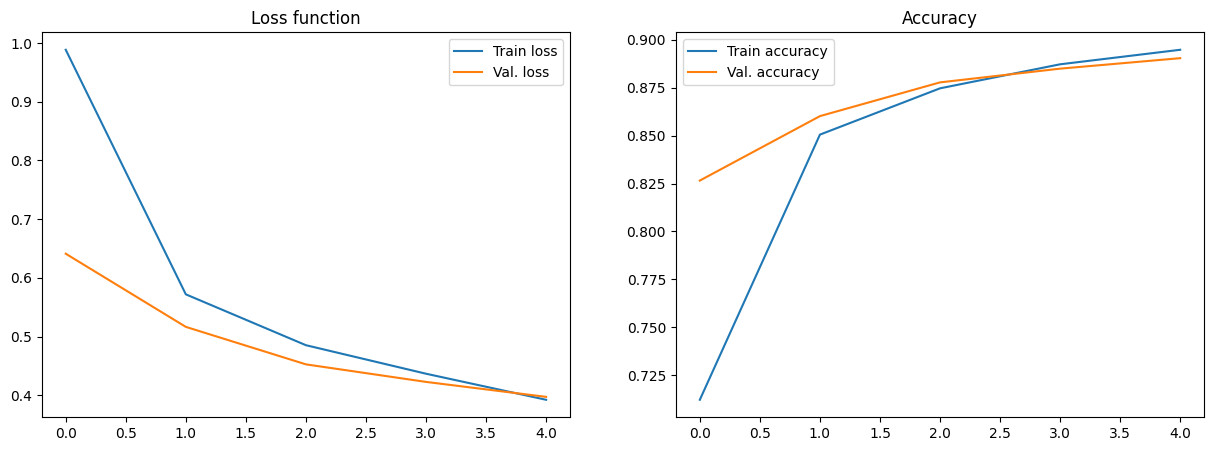

In [16]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.plot(running_loss, label="Train loss")
plt.plot(running_test_loss, label="Val. loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(running_acc, label="Train accuracy")
plt.plot(running_test_acc, label="Val. accuracy")
plt.legend();

<span style="color:green"> No hi ha *overfitting* ja que les dues línies (train i validació) segueixen el mateix patró.</span>

## Tasca a fer

1. Seleccionar la funció de pèrdua a emprar per poder entrenar el model.
2. Afegir la validació al bucle del `MNIST` i contestar a la pregunta de si hi ha *overfitting*?
2. Crear dos objectes `DataLoader` pel següent [dataset](https://github.com/miquelmn/aa_2526/releases/download/pr3/p4.tar.gz). Per fer-ho haureu de primer descarregar les imatges de l'enllaç, i després carregar les dades emprant [ImageFolder](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) de `PyTorch`.
3. Entrenar un **MLP** amb `PyTorch` per tal d'identificar les classes. Prova primer amb una mida d'imatges més petita (64 per 64 píxels) fins a la mida original.

In [30]:
BATCH_SIZE = 8

transform = transforms.Compose([
    transforms.ToTensor(),
	transforms.Resize((64, 64)),
	transforms.ConvertImageDtype(torch.float)
])

dataset_train = datasets.ImageFolder("../data/FunnyBirds/train", transform=transform)
dataset_test = datasets.ImageFolder("../data/FunnyBirds/test", transform=transform)

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

In [52]:
mlp_net_fb = nn.Sequential(
    torch.nn.Linear(64*64*3, 100),
    nn.ReLU(),
    torch.nn.Linear(100, 512),
    torch.nn.Dropout(0.2),
    nn.ReLU(),
	torch.nn.Linear(512, 512),
    torch.nn.Dropout(0.2),
    nn.ReLU(),
	torch.nn.Linear(512, 100),
    torch.nn.Dropout(0.2),
    nn.ReLU(),
    torch.nn.Linear(100, 1)
)

In [53]:
EPOCHS = 10
loss_fn = nn.BCEWithLogitsLoss()
LR = 1e-3
optimizer = torch.optim.Adam(mlp_net_fb.parameters(), lr=LR)

In [54]:
running_loss = []
running_acc = []

running_test_loss = []
running_test_acc = []

for t in tqdm(range(EPOCHS), desc="Epochs"):
    batch_loss = 0
    batch_acc = 0

    batch_val_loss = 0
    batch_val_acc = 0

    i_batch = 0
    for i_batch, (x, y) in enumerate(dataloader_train):  # We have to iter the batches.
        mlp_net_fb.train()
        x = x.reshape(x.shape[0], -1)  # Flatten images

        optimizer.zero_grad()
        y_pred = mlp_net_fb(x).flatten()

        # 1. LOSS CALCULATION
        loss = loss_fn(y_pred, y.float())

        # 2. GRADIENT
        mlp_net_fb.zero_grad()
        loss.backward()

        # 3. OPTIMISATION
        with torch.no_grad():
            optimizer.step()

        # 4. EVALUATION
        mlp_net_fb.eval()  # Mode avaluació de la xarxa

        y_pred = mlp_net_fb(x).flatten()
        y_pred_binary = (y_pred > 0.5).float()

        batch_loss += (loss_fn(y_pred, y.float()).detach())
        batch_acc += accuracy_score(y_pred_binary.detach(), y.detach())

    for i_val_batch, (x_val, y_val) in enumerate(dataloader_test):
        mlp_net_fb.eval()
        x_val = x_val.reshape(x_val.shape[0], -1)  # Flatten

        y_val_pred = mlp_net_fb(x_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).float()

        batch_val_loss += (loss_fn(y_val_pred, y_val.float()).detach())
        batch_val_acc += accuracy_score(y_val_pred_binary.detach(), y_val.detach())

    running_test_loss.append(batch_val_loss / (i_val_batch + 1))
    running_test_acc.append(batch_val_acc / (i_val_batch + 1))

    running_loss.append(batch_loss / (i_batch + 1))
    running_acc.append(batch_acc / (i_batch + 1))

Epochs: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]


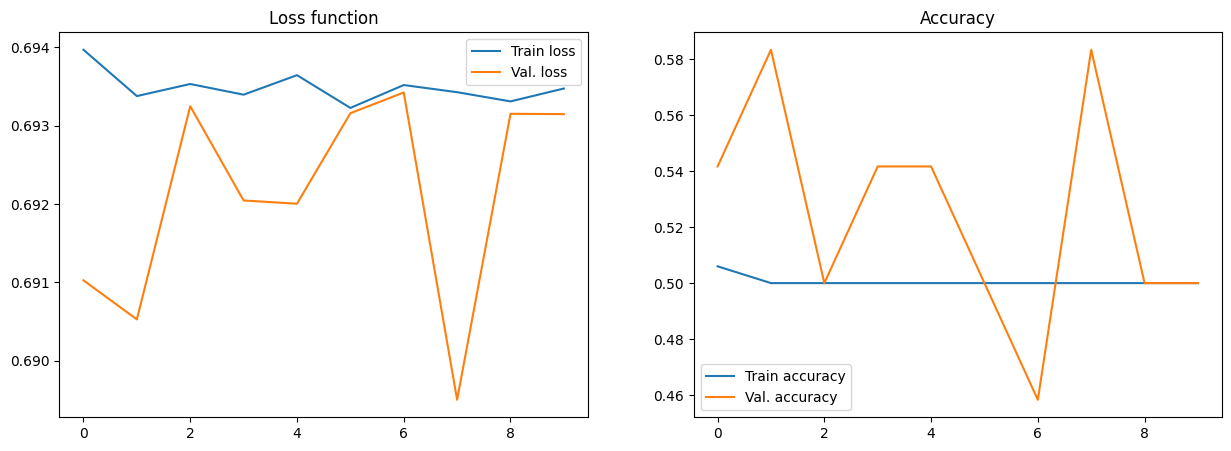

In [55]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.title("Loss function")
plt.plot(running_loss, label="Train loss")
plt.plot(running_test_loss, label="Val. loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy")
plt.plot(running_acc, label="Train accuracy")
plt.plot(running_test_acc, label="Val. accuracy")
plt.legend();